In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import skew,boxcox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [4]:
train_features = pd.read_csv('train_features.csv')
train_targets = pd.read_csv('train_targets_scored.csv')
train_features = train_features.drop('sig_id',axis=1)
train_targets = train_targets.drop('sig_id',axis=1)

In [5]:

train_features, test_features, train_scored, test_scored = train_test_split(train_features, train_targets, test_size=0.2, random_state=42)


In [6]:
train_features = train_features.reset_index(drop=True)
train_targets = train_targets.reset_index(drop=True)
train_scored = train_scored.reset_index(drop=True)
test_scored = test_scored.reset_index(drop = True)

In [7]:
train_features = train_features[:5000]
test_features = test_features[:5000]
train_scored = train_scored[:5000]
test_scored = test_scored[:5000]

PREPROCESSING

In [14]:

def remove_skewness(data) :
    columns = data.columns

    # removing the skewness from the data set
    skew_threshold = 0.5

    for col in columns : 
        skewness_before = skew(data[col])

        if abs(skewness_before) > skew_threshold:
            # Apply Box-Cox transformation and find the best lambda
            min_value = data[col].min()
            if (min_value<=0):
                data[col] += (-min_value+1)
            transformed_data, lambda_best_fit = boxcox(data[col])  # Adding 1 to avoid zero values
            data[col] = transformed_data  # Replace the original feature with the transformed data
        
        skewness_after = skew(data[col])

    return data


def oneHotEncoding(data):
    # performing one hot encoding on discrete features
    discrete_features = ['cp_dose','cp_time','cp_type']
    data = pd.get_dummies(data,columns=discrete_features,dtype=int)
    return data 

def remove_outliers(data,Y):
    s = set()
    columns = data.columns

    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        for index, row in data.iterrows():
            if index in s:
                continue
            if (row[col]<lower_bound or row[col]>upper_bound):
                data = data.drop(index,axis=0)
                
                Y = Y.drop(index,axis=0)
                
                s.add(index)
    data = data.reset_index(drop = True)
    Y = Y.reset_index(drop = True)
    data = pd.DataFrame(data)
    Y = pd.DataFrame(Y)
    return data, Y

In [15]:
def cross_entropy(predicted_probabilities,true_labels):
    # Compute cross-entropy loss
    epsilon = 1e-15  # A small constant to prevent numerical instability (avoid log(0))
    predicted_probabilities = np.clip(predicted_probabilities, epsilon, 1 - epsilon)  # Clip probabilities
    cross_entropy_loss = -np.mean(true_labels * np.log(predicted_probabilities) + (1 - true_labels) * np.log(1 - predicted_probabilities))
    return cross_entropy_loss

In [32]:
kfold = 3

# Initialize a KFold object
kf = KFold(n_splits=kfold, shuffle=True, random_state=42)


penalty = [0.01,0.1,0.5,1,3,5,10,15]

# Initialize a list to store the cross-validation accuracies


# Perform k-fold cross-validation with PCA
itr = 0

pc = [4,10,15,40,60,80]
contamination = [0.01,0.005,0.1,0.2]
neighbour = [5,10,25,50,100,200,300]
avg_training = []
avg_validation = []

for i in range(len(pc)):
    cross_val_scores = []
    train_cross_val_score = []
    for train_index, test_index in kf.split(train_features):


        clf = LogisticRegression(penalty = 'l1', C = 0.5, max_iter=10000,solver='liblinear')


        # Split the data into training and testing sets for this fold
        X_train, X_test = train_features.iloc[train_index], train_features.iloc[test_index]
        y_train, y_test = train_scored.iloc[train_index], train_scored.iloc[test_index]

        
        X_train = oneHotEncoding(X_train)
        X_test = oneHotEncoding(X_test)
        
        # lof_model = LocalOutlierFactor(n_neighbors=neighbour[itr], contamination=0.01)

        # # Fit the model and identify outliers
        # outlier_scores = lof_model.fit_predict(X_train)
        # outlier_indices = X_train.index[outlier_scores == -1]

        # X_train = X_train.drop(outlier_indices)
        # y_train  = y_train.drop(outlier_indices)

        # X_train = X_train.reset_index(drop=True)
        # y_train = y_train.reset_index(drop=True)

        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        # Initialize a PCA object (you can adjust the number of components)
        pca = PCA(n_components=pc[itr])
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        X_test  = pca.transform(X_test)

        test_columns = y_train.columns
        loss = 0
        loss_train = 0
        for col in test_columns:
            if (y_train[col].unique().shape[0]==1):
                y_pred = [0.001 for x in range(len(X_test))]
                y_train_pred = [0.001 for x in range(len(X_train))]
            # Train a classifier on the transformed training data
            else:
                clf.fit(X_train, y_train[col])
            
                y_train_pred = clf.predict_proba(X_train)
                y_train_pred = [row[1] for row in y_train_pred]
                # Make predictions on the transformed test data
                y_pred = clf.predict_proba(X_test)

                # print(y_pred)
                y_pred = [row[1] for row in y_pred]
                
                # print(y_pred)
                # print(y_train_pred)
            
            loss += cross_entropy(y_pred,y_test[col].values)

            loss_train += cross_entropy(y_train_pred,y_train[col].values)
        cross_val_scores.append(loss/test_columns.shape[0])
        train_cross_val_score.append(loss_train/test_columns.shape[0])

    itr += 1
    print(f"---------------------------------------{itr}----------------------------------------")
    # Calculate the mean and standard deviation of cross-validation scores
    print(f"cross validation score for training : {train_cross_val_score}")
    print(f"cross validation scores : {cross_val_scores}")
    mean_accuracy = np.mean(cross_val_scores)
    std_accuracy = np.std(cross_val_scores)
    print(f"mean loss : {mean_accuracy}")
    print(f"std dev of loss : {std_accuracy}")
    print("---------------------------------------------------------------------------------")


    avg_training.append(np.mean(train_cross_val_score))
    avg_validation.append(np.mean(cross_val_scores))


---------------------------------------1----------------------------------------
cross validation score for training : [0.018750273065884806, 0.01875009271437563, 0.018576894336407704]
cross validation scores : [0.01921143317513121, 0.01923890663136535, 0.019556715496993764]
mean loss : 0.019335685101163444
std dev of loss : 0.0001566940216048337
---------------------------------------------------------------------------------
---------------------------------------2----------------------------------------
cross validation score for training : [0.017411037969602014, 0.01748168152999751, 0.017297823373141015]
cross validation scores : [0.018594023347950902, 0.0186733925679642, 0.01883719200771026]
mean loss : 0.01870153597454179
std dev of loss : 0.00010124816960529527
---------------------------------------------------------------------------------
---------------------------------------3----------------------------------------
cross validation score for training : [0.01676507630793534

In [17]:
print(avg_training)

[0.014235818347600973]


In [18]:
print(avg_validation)

[0.017984606935285388]


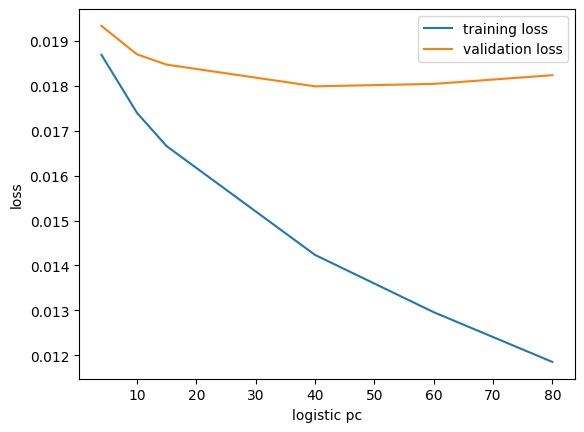

In [34]:
plt.plot(pc,avg_training,label = 'training loss')
plt.plot(pc,avg_validation,label = 'validation loss')
plt.xlabel('logistic pc')
plt.ylabel('loss')
plt.legend()
plt.show()

In [1]:
clf = LogisticRegression(penalty = 'l1', C = 0.5, max_iter=10000,solver='liblinear')
X_train = train_features
y_train = train_scored

X_test = test_features
y_test = test_scored

X_train = oneHotEncoding(X_train)
X_test = oneHotEncoding(X_test)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(n_components=50)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test  = pca.transform(X_test)

test_columns = y_test.columns
loss = 0
loss_train = 0
for col in test_columns:
    if (y_train[col].unique().shape[0]==1):
        y_pred = [0.001 for x in range(len(X_test))]
        y_train_pred = [0.001 for x in range(len(X_train))]

        # Train a classifier on the transformed training data
    else:
        clf.fit(X_train, y_train[col])

        y_train_pred = clf.predict_proba(X_train)
        y_train_pred = [row[1] for row in y_train_pred]
        # Make predictions on the transformed test data
        y_pred = clf.predict_proba(X_test)
        y_pred = [row[1] for row in y_pred]
        
    
    loss += cross_entropy(y_pred,y_test[col].values)

    loss_train += cross_entropy(y_train_pred,y_train[col].values)


print(loss)
print(loss_train)
print(f"Test Loss : {loss/test_columns.shape[0]}")
print(f"Training Loss : {loss_train/test_columns.shape[0]}")

NameError: name 'LogisticRegression' is not defined